Crop Disease Classification using Transfer Learning

Importing Plant Village Dataset from Kaggle

In [ ]:
!pip install torch torchvision scikit-learn

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 97% 635M/658M [00:03<00:00, 58.1MB/s]
100% 658M/658M [00:03<00:00, 186MB/s] 


In [ ]:
!unzip plantdisease.zip

Train Test Split of Dataset

In [ ]:
import os
import shutil
import random

source = "PlantVillage"
train_dir = "dataset/train"
val_dir = "dataset/val"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(source):
    class_path = os.path.join(source, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    split = int(0.8 * len(images))
    train_images = images[:split]
    val_images = images[split:]

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(train_dir, class_name, img))

    for img in val_images:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(val_dir, class_name, img))

Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
train_dataset = datasets.ImageFolder("dataset/train", transform=transform)
val_dataset   = datasets.ImageFolder("dataset/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Classes:", train_dataset.classes)

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


Loading MobileNet V3

In [ ]:
model = models.mobilenet_v3_small(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_classes = len(train_dataset.classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 129MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[3].parameters(), lr=0.001)

Training the model

In [ ]:
for epoch in range(3):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 0.7280044026037519
Epoch 2, Loss: 0.33795854000215847
Epoch 3, Loss: 0.27066352921574155


Validation Set

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print("Validation Accuracy:", acc)

Validation Accuracy: 0.9230769230769231


The model achieved 92% validation accuracy after 3 epochs using transfer learning. 
Most misclassifications occur between visually similar leaf diseases.

Confusion Matrix

In [ ]:
print(confusion_matrix(all_labels, all_preds))

[[191   4   0   0   0   0   0   2   0   1   1   1   0   0   0]
 [  1 293   0   0   0   0   0   2   0   0   0   0   0   0   0]
 [  1   0 196   0   0   0   0   1   0   2   0   0   0   0   0]
 [  0   0   1 186   1   1   1  10   0   0   0   0   0   0   0]
 [  0   1   0   0  28   0   0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   0 401   8   4   0   7   0   1   5   0   0]
 [  3   0   3   1   0  10 139  21   2   7   0   6   4   3   1]
 [  0   1   0   8   0   1  16 325   5   2   3  12   3   0   6]
 [  1   1   0   0   0   0   3   3 171   6   2   0   3   0   1]
 [  2   0   2   0   0  11   0   8   2 317   2   3   6   1   1]
 [  0   0   0   1   0   1   3   0   0   1 310  16   1   3   0]
 [  0   1   1   0   0   4   2   1   1   4  19 244   0   1   3]
 [  0   0   0   0   0   7   0   0   0   1   4   3 627   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0  73   1]
 [  0   0   0   0   0   0   0   1   1   0   0   2   0   0 315]]


Saving Weights

In [ ]:
torch.save(model.state_dict(), "plant_disease_model.pth")

Sample Prediction Cell

In [ ]:
print(os.listdir("dataset/val/Tomato_Early_blight")[:5])

['0f7a2408-9c26-4ff9-bee5-2bfcd91a11f7___RS_Erly.B 9440.JPG', '3a7c19c6-a86d-4127-b00e-600cb0244ac4___RS_Erly.B 6415.JPG', '3af16e88-1b4d-46d5-a099-7450600f11e8___RS_Erly.B 9545.JPG', '0982d864-182e-4d36-959a-dcc67d85d9e6___RS_Erly.B 9481.JPG', '801083ae-26f9-4a9a-9e9a-f73fb18b67e5___RS_Erly.B 7363.JPG']


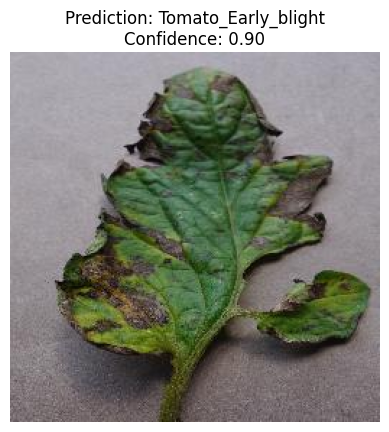

In [ ]:
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

img_path = "dataset/val/Tomato_Early_blight/0f7a2408-9c26-4ff9-bee5-2bfcd91a11f7___RS_Erly.B 9440.JPG"

image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(input_tensor)
    probs = F.softmax(output, dim=1)
    confidence, pred = torch.max(probs, 1)

plt.imshow(image)
plt.title(f"Prediction: {train_dataset.classes[pred.item()]}\nConfidence: {confidence.item():.2f}")
plt.axis("off")
plt.show()